# **Análise de Dados - Hipertensão**

## Importando as bibliotecas necessárias

In [1]:
!pip install pycaret

     |████████████████████████████████| 319 kB 5.3 MB/s 
     |████████████████████████████████| 16.5 MB 140 kB/s 
     |████████████████████████████████| 2.0 MB 37.5 MB/s 
     |████████████████████████████████| 114 kB 68.2 MB/s 
     |████████████████████████████████| 261 kB 57.6 MB/s 
     |████████████████████████████████| 86 kB 5.0 MB/s 
     |████████████████████████████████| 1.7 MB 47.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 167 kB 56.6 MB/s 
     |████████████████████████████████| 56 kB 3.8 MB/s 
     |████████████████████████████████| 6.8 MB 25.4 MB/s 
     |████████████████████████████████| 1.3 MB 51.8 MB/s 
     |████████████████████████████████| 303 kB 50.9 MB/s 
     |████████████████████████████████| 3.1 MB 31.0 MB/s 
     |████████████████████████████████| 102 kB 8.5 MB/s 
     |███████████████████

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files



## Importando os dados

In [ ]:
uploaded = files.upload()

Saving demographic.csv to demographic.csv
Saving diet.csv to diet.csv
Saving examination.csv to examination.csv
Saving labs.csv to labs.csv
Saving medications.csv to medications.csv
Saving questionnaire.csv to questionnaire.csv


## Juntando os datasets

In [98]:
## dataset 'medications' == 'questionnaire'
demo = pd.read_csv('demographic.csv')
diet = pd.read_csv('diet.csv')
exam = pd.read_csv('examination.csv')
labs = pd.read_csv('labs.csv')
quest = pd.read_csv('questionnaire.csv')


In [99]:
demo.drop(['SEQN'], axis=1, inplace=True)
diet.drop(['SEQN'], axis=1, inplace=True)
exam.drop(['SEQN'], axis=1, inplace=True)
labs.drop(['SEQN'], axis=1, inplace=True)
quest.drop(['SEQN'], axis=1, inplace=True)

In [100]:
df = pd.concat([demo, diet, exam, labs, quest], axis=1, join='inner')


In [101]:
df.head()

,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,...,WHD080U,WHD080L,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ030M,WHQ500,WHQ520
0,8,2,1,69,NaN,4,4,1.0,NaN,1.0,...,NaN,40.0,270.0,200.0,69.0,270.0,62.0,NaN,NaN,NaN
1,8,2,1,54,NaN,3,3,1.0,NaN,2.0,...,NaN,NaN,240.0,250.0,72.0,250.0,25.0,NaN,NaN,NaN
2,8,2,1,72,NaN,3,3,2.0,NaN,1.0,...,NaN,NaN,180.0,190.0,70.0,228.0,35.0,NaN,NaN,NaN
3,8,2,1,9,NaN,3,3,1.0,119.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0
4,8,2,2,73,NaN,3,3,1.0,NaN,2.0,...,NaN,NaN,150.0,135.0,67.0,170.0,60.0,NaN,NaN,NaN


In [6]:
df.shape

(9813, 1811)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9813 entries, 0 to 9812
Columns: 1811 entries, SDDSRVYR to WHQ520
dtypes: float64(1753), int64(27), object(31)
memory usage: 135.6+ MB


## Eliminando colunas 'duplicadas' que servem apenas para conversão de unidades

In [102]:
cols = [c for c in df.columns if c[-2:]!= 'SI']

## Definindo as colunas que serão usadas

In [104]:
## hipertensão (blood pressure)
#df = df[['ALQ101', 'BMXBMI', 'BMXWT', 'BPQ020', 'BPQ080', 'BPXSY1', 'BPXDI1', 'HSD010', 'LBXMC', 'MCQ160B', 'MCQ160C', 'MCQ160D', 'MCQ160E', 'MCQ160F', 'MCQ300A', 'MCQ370B', 'PEASCST1', 'RIAGENDR', 'RIDAGEYR', 'WHD010', 'SMQ040']]


## hipertensão (blood pressure - versao streaming)
df = df[['ALQ101', 'BMXBMI', 'BMXWT', 'BPQ020', 'BPQ080', 'BPXSY1', 'LBXMC', 'MCQ160B', 'MCQ160F', 'MCQ300A', 'MCQ370B', 'RIAGENDR', 'RIDAGEYR', 'WHD010', 'SMQ040']]



# Dicionário de Features

In [105]:
''' col_decoder = {
'ALQ101' : 'Drink_alcohol',             # Drink_Alcohol - Had at least 12 alcohol drinks/1 yr? ------ 0 = no  1 = yes      
'BMXBMI' : 'BMI',                       # BMI      - Body Mass Index / 
'BMXWT' : 'Weight_kg',                  # Weight in Kilograms 
'BPQ020' : 'HighBP',                   # HighBP   - High Blood Pressure  ------  0 = no high BP 1 = high BP
'BPQ080' : 'HighChol',          # HighCholesterol - High Cholesterol ----------- 0 = no high cholesterol  1 = high cholesterol
'BPXSY1' : 'Systolic_bp',               # Systolic: Blood pres (1st rdg) mm Hg 
'BPXDI1' : 'Diastolic_bp',              # Diastolic: Blood pres (1st rdg) mm Hg
'HSD010' : 'GenHlth',            # General Health Condition ------ 1 = Excelent  2 = Very good  3 = Good  4 = Fair  5 = Poor   
'LBXMC' : 'Hemoglobin_concentration',   # Mean cell hemoglobin concentration (g/dL)
'MCQ160B' : 'Congestive_heart_failure', # Ever told had congestive heart failure ------  0 = no  1 = yes
'MCQ160C' : 'Coronary_heart_disease',   # Ever told you had coronary heart disease ------  0 = no  1 = yes
'MCQ160D' : 'Angina',                   # Ever told you had angina/angina pectoris ------  0 = no  1 = yes
'MCQ160E' : 'Heart_attack',             # Ever told you had heart attack ------  0 = no  1 = yes 
'MCQ160F' : 'Stroke',                   # Ever told you had a stroke ------ 0 = no 1 = yes
'MCQ300A' : 'Relative_heart_attack',    # Close relative had heart attack ------  0 = no  1 = yes
'MCQ370B' : 'Exercising',               # Are you now increasing exercise ------  0 = no  1 = yes
'PEASCST1' : 'BP_status',               # Blood Pressure Status ------ 0 = parcial  1 = complete  3 = not done     
'RIAGENDR' : 'Sex',                  # Gender - 0 = female 1 = male
'RIDAGEYR' : 'Age',                     # Age - 13-level age category  1 = 18-24    9 = 60-64    13 = 80 or older
'SMQ040' : 'Smoker',                   # Smoking - 
'WHD010' : 'Height_cm',                 # Height in Centimeters
}
 '''


col_decoder = {
'ALQ101' : 'Drink_alcohol',             # Drink_Alcohol - Had at least 12 alcohol drinks/1 yr? ------ 0 = no  1 = yes      
'BMXBMI' : 'BMI',                       # BMI      - Body Mass Index / 
'BMXWT' : 'Weight_kg',                  # Weight in Kilograms 
'BPQ020' : 'HighBP',                   # HighBP   - High Blood Pressure  ------  0 = no high BP 1 = high BP
'BPQ080' : 'HighChol',          # HighCholesterol - High Cholesterol ----------- 0 = no high cholesterol  1 = high cholesterol
'BPXSY1' : 'Systolic_bp',               # Systolic: Blood pres (1st rdg) mm Hg 
'LBXMC' : 'Hemoglobin_concentration',   # Mean cell hemoglobin concentration (g/dL)
'MCQ160B' : 'Congestive_heart_failure', # Ever told had congestive heart failure ------  0 = no  1 = yes
'MCQ160F' : 'Stroke',                   # Ever told you had a stroke ------ 0 = no 1 = yes
'MCQ300A' : 'Relative_heart_attack',    # Close relative had heart attack ------  0 = no  1 = yes
'MCQ370B' : 'Exercising',               # Are you now increasing exercise ------  0 = no  1 = yes
'RIAGENDR' : 'Sex',                  # Gender - 0 = female 1 = male
'RIDAGEYR' : 'Age',                     # Age - 13-level age category  1 = 18-24    9 = 60-64    13 = 80 or older
'SMQ040' : 'Smoker',                   # Smoking - 
'WHD010' : 'Height_cm',                 # Height in Centimeters
}

In [106]:
df = df.rename(columns = col_decoder)

## Convertendo dados para as medidas corretas

In [107]:
df['Height_cm'] = df['Height_cm'] * 2.54

In [108]:
df.head()

,Drink_alcohol,BMI,Weight_kg,HighBP,HighChol,Systolic_bp,Hemoglobin_concentration,Congestive_heart_failure,Stroke,Relative_heart_attack,Exercising,Sex,Age,Height_cm,Smoker
0,1.0,26.7,78.3,1.0,1.0,122.0,33.4,2.0,1.0,2.0,2.0,1,69,175.26,3.0
1,1.0,28.6,89.5,1.0,1.0,156.0,32.5,2.0,2.0,2.0,2.0,1,54,180.34,2.0
2,1.0,28.9,88.9,1.0,1.0,140.0,34.3,2.0,2.0,1.0,2.0,1,72,177.80,3.0
3,NaN,17.1,32.2,NaN,NaN,108.0,34.0,NaN,NaN,NaN,NaN,1,9,NaN,NaN
4,1.0,19.7,52.0,1.0,2.0,136.0,33.0,2.0,2.0,1.0,2.0,2,73,170.18,NaN


## Lidando com Nulls

In [109]:
## Quando o paciente se recusa a responder uma questão ou quando 'não se aplica', são usadas combinações de números 7 e 9
df.replace({7:None, 9:None, 77:None, 99:None, 777:None, 999:None, 7777:None, 9999:None, 77777:None, 99999:None, 777777:None, 999999:None, 55:None, 555:None, 5555:None, 8:None, 88:None}, inplace=True)


In [110]:
df = df.dropna()

In [111]:
df.nunique()

Drink_alcohol                 2
BMI                         316
Weight_kg                   695
HighBP                        2
HighChol                      2
Systolic_bp                  56
Hemoglobin_concentration     60
Congestive_heart_failure      2
Stroke                        2
Relative_heart_attack         2
Exercising                    2
Sex                           2
Age                          59
Height_cm                    26
Smoker                        3
dtype: int64

In [112]:
# df[['Drink_alcohol',	'HighBP',	'HighChol',	'Congestive_heart_failure', 'Coronary_heart_disease',	'Angina',	'Heart_attack',	'Stroke',	'Relative_heart_attack',	'Exercising',	'BP_status']] = df[['Drink_alcohol',	'HighBP',	'HighChol',	'Congestive_heart_failure', 'Coronary_heart_disease',	'Angina',	'Heart_attack',	'Stroke',	'Relative_heart_attack',	'Exercising',	'BP_status']].replace(2.0,0)

df[['Drink_alcohol',	'HighBP',	'HighChol',	'Congestive_heart_failure',	'Stroke',	'Relative_heart_attack',	'Exercising']] = df[['Drink_alcohol',	'HighBP',	'HighChol',	'Congestive_heart_failure',	'Stroke',	'Relative_heart_attack',	'Exercising']].replace(2.0,0)

In [113]:
df.head()

,Drink_alcohol,BMI,Weight_kg,HighBP,HighChol,Systolic_bp,Hemoglobin_concentration,Congestive_heart_failure,Stroke,Relative_heart_attack,Exercising,Sex,Age,Height_cm,Smoker
0,1.0,26.7,78.3,1.0,1.0,122.0,33.4,0.0,1.0,0.0,0.0,1,69.0,175.26,3.0
1,1.0,28.6,89.5,1.0,1.0,156.0,32.5,0.0,0.0,0.0,0.0,1,54.0,180.34,2.0
2,1.0,28.9,88.9,1.0,1.0,140.0,34.3,0.0,0.0,1.0,0.0,1,72.0,177.80,3.0
5,1.0,41.7,105.0,1.0,1.0,160.0,34.2,0.0,0.0,0.0,1.0,1,56.0,162.56,3.0
9,1.0,22.0,65.3,0.0,0.0,140.0,35.3,0.0,0.0,0.0,1.0,2,56.0,154.94,1.0


## Removendo linhas e colunas com grande quantidade de nulls

In [114]:
def filter_columns(df, cutoff=0.9):
    tot_rows = df.shape[0]
    removed_cols = []
   
    for col in df.columns:
        num_na = df[col].isna().sum()
        if (num_na/tot_rows) > cutoff:
            removed_cols.append(col)
    return df.drop(removed_cols, axis=1)
    
def filter_rows(df, cutoff=0.9):
    tot_cols = df.shape[1]
    df = df[df.isnull().sum(axis=1) < tot_cols*cutoff]
    return df

In [115]:
df.isnull().sum()

Drink_alcohol               0
BMI                         0
Weight_kg                   0
HighBP                      0
HighChol                    0
Systolic_bp                 0
Hemoglobin_concentration    0
Congestive_heart_failure    0
Stroke                      0
Relative_heart_attack       0
Exercising                  0
Sex                         0
Age                         0
Height_cm                   0
Smoker                      0
dtype: int64

In [116]:
df = df[df['Age'] > 18]

In [117]:
df.shape

(1336, 15)

In [118]:
df.sample(10)

,Drink_alcohol,BMI,Weight_kg,HighBP,HighChol,Systolic_bp,Hemoglobin_concentration,Congestive_heart_failure,Stroke,Relative_heart_attack,Exercising,Sex,Age,Height_cm,Smoker
5011,1.0,20.4,45.0,0.0,0.0,158.0,33.4,0.0,0.0,1.0,0.0,2,29.0,157.48,1.0
3702,0.0,16.4,32.1,0.0,0.0,110.0,33.9,0.0,0.0,1.0,0.0,1,24.0,180.34,1.0
2439,1.0,27.6,85.5,0.0,0.0,122.0,33.4,0.0,0.0,0.0,1.0,1,61.0,187.96,3.0
7967,1.0,25.9,77.7,1.0,0.0,146.0,33.1,1.0,0.0,1.0,0.0,1,73.0,162.56,3.0
5443,1.0,28.4,90.5,0.0,0.0,136.0,32.9,0.0,0.0,0.0,0.0,1,36.0,165.10,3.0
2866,1.0,33.1,105.4,1.0,1.0,138.0,34.3,0.0,0.0,0.0,0.0,2,74.0,162.56,3.0
2843,1.0,21.2,60.9,0.0,1.0,100.0,34.0,0.0,0.0,0.0,0.0,1,61.0,170.18,3.0
4295,1.0,30.4,100.0,0.0,0.0,142.0,34.2,0.0,0.0,0.0,1.0,1,72.0,160.02,3.0
4824,1.0,17.9,35.8,0.0,0.0,98.0,33.1,0.0,0.0,0.0,1.0,1,21.0,198.12,1.0
8633,1.0,29.7,79.9,0.0,1.0,134.0,34.2,0.0,0.0,1.0,0.0,1,45.0,175.26,3.0


In [119]:
df.describe()

,Drink_alcohol,BMI,Weight_kg,HighBP,HighChol,Systolic_bp,Hemoglobin_concentration,Congestive_heart_failure,Stroke,Relative_heart_attack,Exercising,Sex,Age,Height_cm,Smoker
count,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000
mean,0.868263,27.353967,74.880689,0.416916,0.388473,118.764970,33.815419,0.038174,0.044162,0.139222,0.559880,1.428892,50.988024,340.078623,2.191617
std,0.338331,7.472545,24.695755,0.493233,0.487586,18.288864,1.365208,0.191687,0.205531,0.346307,0.496587,0.495103,17.125617,2064.378193,0.934942
min,0.000000,13.200000,19.500000,0.000000,0.000000,74.000000,29.200000,0.000000,0.000000,0.000000,0.000000,1.000000,20.000000,137.160000,1.000000
25%,1.000000,22.400000,59.300000,0.000000,0.000000,106.000000,33.200000,0.000000,0.000000,0.000000,0.000000,1.000000,36.000000,162.560000,1.000000
50%,1.000000,26.300000,73.700000,0.000000,0.000000,116.000000,33.800000,0.000000,0.000000,0.000000,1.000000,1.000000,52.000000,170.180000,3.000000
75%,1.000000,31.100000,88.600000,1.000000,1.000000,128.000000,34.500000,0.000000,0.000000,0.000000,1.000000,2.000000,65.000000,177.800000,3.000000
max,1.000000,70.100000,184.500000,1.000000,1.000000,220.000000,69.600000,1.000000,1.000000,1.000000,1.000000,2.000000,80.000000,25397.460000,3.000000


In [120]:
df = df.apply(pd.to_numeric)

# Machine Learning e seleção do melhor modelo

In [122]:
from pycaret.classification import *

In [123]:
# cat_features = ['Sex', 'Drink_alcohol', 'HighChol', 'GenHlth', 'Congestive_heart_failure', 'Coronary_heart_disease', 'Angina', 'Heart_attack', 'Stroke', 'Relative_heart_attack', 'Exercising', 'BP_status', 'Smoker'] 

cat_features = ['Sex', 'Drink_alcohol', 'HighChol', 'Congestive_heart_failure', 'Stroke', 'Relative_heart_attack', 'Exercising', 'Smoker'] 

numeric_features = ['BMI', 'Weight_kg', 'Systolic_bp', 'Hemoglobin_concentration', 'Age', 'Height_cm']


In [124]:
s = setup(data = df, target='HighBP', train_size=0.75, numeric_features=numeric_features, categorical_features=cat_features, normalize=True, normalize_method="minmax")

,Description,Value
0,session_id,1153
1,Target,HighBP
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(1336, 15)"
5,Missing Values,False
6,Numeric Features,6
7,Categorical Features,8
8,Ordinal Features,False
9,High Cardinality Features,False


In [125]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6967,0.7551,0.5471,0.6483,0.5923,0.3541,0.3578,0.335
lda,Linear Discriminant Analysis,0.6957,0.7546,0.5693,0.6393,0.6012,0.3569,0.3591,0.019
gbc,Gradient Boosting Classifier,0.6936,0.7344,0.5616,0.6391,0.5952,0.3511,0.3545,0.180
ridge,Ridge Classifier,0.6907,0.0000,0.5544,0.6354,0.5908,0.3444,0.3473,0.017
rf,Random Forest Classifier,0.6866,0.7322,0.5396,0.6378,0.5816,0.3344,0.3394,0.552
svm,SVM - Linear Kernel,0.6697,0.0000,0.4702,0.6595,0.4972,0.2828,0.3167,0.020
ada,Ada Boost Classifier,0.6667,0.7236,0.5222,0.6032,0.5579,0.2930,0.2960,0.130
lightgbm,Light Gradient Boosting Machine,0.6637,0.7153,0.5471,0.5945,0.5677,0.2938,0.2959,0.107
et,Extra Trees Classifier,0.6477,0.7040,0.4877,0.5773,0.5262,0.2500,0.2533,0.511
nb,Naive Bayes,0.6437,0.7130,0.2443,0.6675,0.3530,0.1777,0.2210,0.021


In [126]:
model = create_model('lr', fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6667,0.7322,0.5062,0.6029,0.5503,0.2887,0.2915
1,0.7512,0.8069,0.6341,0.7222,0.6753,0.4751,0.4777
2,0.7050,0.7765,0.5309,0.6719,0.5931,0.3667,0.3729
3,0.6800,0.7557,0.5062,0.6308,0.5616,0.3144,0.3191
4,0.6700,0.6943,0.5432,0.6027,0.5714,0.3043,0.3054
Mean,0.6946,0.7531,0.5441,0.6461,0.5904,0.3498,0.3533
Std,0.0314,0.0383,0.0472,0.0457,0.0447,0.0679,0.0680


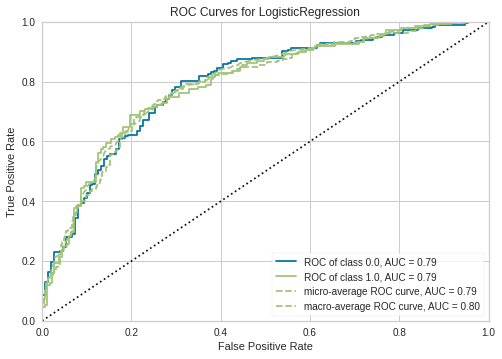

In [127]:
plot_model(model)

In [ ]:
#plot_model(model, 'confusion matrix')

ValueError: ignored

In [128]:
tuned_lr = tune_model(model
                      ,fold = 5
                      ,optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6716,0.7322,0.6420,0.5843,0.6118,0.3284,0.3295
1,0.7413,0.8063,0.7927,0.6500,0.7143,0.4821,0.4901
2,0.7100,0.7763,0.6790,0.6322,0.6548,0.4053,0.4061
3,0.6500,0.7544,0.6420,0.5591,0.5977,0.2906,0.2927
4,0.6650,0.6970,0.6790,0.5729,0.6215,0.3249,0.3286
Mean,0.6876,0.7532,0.6869,0.5997,0.6400,0.3662,0.3694
Std,0.0334,0.0373,0.0554,0.0352,0.0416,0.0690,0.0708


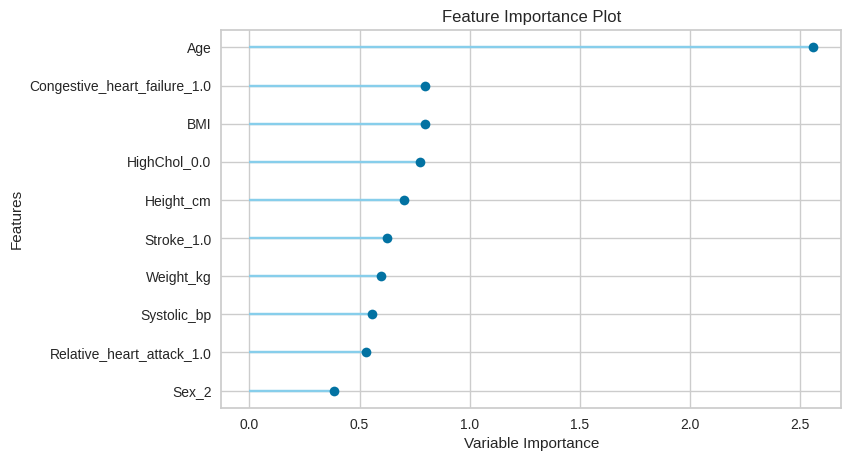

In [129]:
plot_model(estimator = tuned_lr, plot = 'feature')

In [130]:
df_predict = predict_model(tuned_lr, data=df)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7028,0.7716,0.7002,0.629,0.6627,0.3985,0.4003


In [131]:
df_predict


,Drink_alcohol,BMI,Weight_kg,HighBP,HighChol,Systolic_bp,Hemoglobin_concentration,Congestive_heart_failure,Stroke,Relative_heart_attack,Exercising,Sex,Age,Height_cm,Smoker,Label,Score
0,1.0,26.7,78.3,1.0,1.0,122.0,33.4,0.0,1.0,0.0,0.0,1,69.0,175.26,3.0,1.0,0.7873
1,1.0,28.6,89.5,1.0,1.0,156.0,32.5,0.0,0.0,0.0,0.0,1,54.0,180.34,2.0,1.0,0.5561
2,1.0,28.9,88.9,1.0,1.0,140.0,34.3,0.0,0.0,1.0,0.0,1,72.0,177.80,3.0,1.0,0.8030
5,1.0,41.7,105.0,1.0,1.0,160.0,34.2,0.0,0.0,0.0,1.0,1,56.0,162.56,3.0,1.0,0.6570
9,1.0,22.0,65.3,0.0,0.0,140.0,35.3,0.0,0.0,0.0,1.0,2,56.0,154.94,1.0,1.0,0.5144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9788,1.0,22.5,57.7,0.0,1.0,106.0,34.9,0.0,0.0,1.0,0.0,1,54.0,185.42,3.0,1.0,0.6302
9790,1.0,24.3,71.7,0.0,1.0,116.0,34.3,0.0,0.0,1.0,0.0,2,80.0,170.18,3.0,1.0,0.8846
9794,1.0,23.7,62.5,0.0,1.0,118.0,31.2,0.0,0.0,1.0,0.0,1,63.0,177.80,3.0,1.0,0.7221
9799,1.0,27.4,74.7,0.0,0.0,114.0,33.7,0.0,0.0,0.0,0.0,2,21.0,157.48,1.0,0.0,0.8528


In [132]:
df_predict["Label"].value_counts()

0.0    716
1.0    620
Name: Label, dtype: int64

In [133]:
final = finalize_model(tuned_lr)

In [134]:
saved = save_model(final, 'model')

Transformation Pipeline and Model Successfully Saved


In [135]:
my_model = load_model('model')

Transformation Pipeline and Model Successfully Loaded


In [139]:

'''
data_teste = pd.DataFrame()
data_teste['HighBP'] = [1]  
data_teste['HighChol'] = [1]
data_teste['BMI'] = [31]
data_teste['Smoker'] = [1] 
data_teste['Stroke'] = [1]
data_teste['HeartDiseaseorAttack'] = [1] 
data_teste['Fruits'] = [0] 
data_teste['Veggies'] = [0]
data_teste['HvyAlcoholConsump'] = [1]
data_teste['GenHlth'] = [5]
data_teste['Sex'] = [1]
data_teste['Age'] = [63]
data_teste['Drink_alcohol'] = [1]
data_teste['Weight_kg'] = [100]
data_teste['Systolic_bp'] = [135]
data_teste['Diastolic_bp'] = [60]
data_teste['Hemoglobin_concentration'] = [32]
data_teste['Congestive_heart_failure'] = [0]
data_teste['Coronary_heart_disease'] = [0]
data_teste['Angina'] = [0]
data_teste['Heart_attack'] = [0]
data_teste['Relative_heart_attack'] = [1]
data_teste['Exercising'] = [0]
data_teste['BP_status'] = [1]
data_teste['Height_cm'] = [180]
'''

data_teste = pd.DataFrame()
data_teste['HighChol'] = [1.0]
data_teste['BMI'] = [28.0]
data_teste['Smoker'] = [1.0] 
data_teste['Stroke'] = [1.0]
data_teste['Sex'] = [1.0]
data_teste['Age'] = [33.0]
data_teste['Drink_alcohol'] = [1.0]
data_teste['Weight_kg'] = [54.0]
data_teste['Systolic_bp'] = [120.0]
data_teste['Hemoglobin_concentration'] = [33.0]
data_teste['Congestive_heart_failure'] = [0.0]
data_teste['Relative_heart_attack'] = [0.0]
data_teste['Exercising'] = [0.0]
data_teste['Height_cm'] = [165.0]



''' data_teste = pd.DataFrame()
data_teste['HighChol'] = [0.0]
data_teste['BMI'] = [22.0]
data_teste['Smoker'] = [0.0] 
data_teste['Stroke'] = [0.0]
data_teste['Sex'] = [1.0]
data_teste['Age'] = [33.0]
data_teste['Drink_alcohol'] = [0.0]
data_teste['Weight_kg'] = [54.0]
data_teste['Systolic_bp'] = [120.0]
data_teste['Hemoglobin_concentration'] = [33.0]
data_teste['Congestive_heart_failure'] = [0.0]
data_teste['Relative_heart_attack'] = [0.0]
data_teste['Exercising'] = [1.0]
data_teste['Height_cm'] = [165.0]
'''


#realiza a predição.
result = predict_model(my_model, data=data_teste)

#recupera os resultados.
classe = result["Label"][0]
prob = result["Score"][0]*100

print(classe)
print(prob)


1.0
60.809999999999995
